# Import Lib

In [163]:
import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage.morphology import square,dilation,erosion
from skimage.io import imshow
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# Function

In [186]:
def region_of_interest(img, vertices):   
    mask = np.zeros_like(img)
    match_mask_color = (255,)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    
def findSlope(start,end,height):
    x1 = start[0]
    x2 = end[0]
    y1 = height-start[1]
    y2 = height-end[1]
    print(x1,x2,y1,y2)
#     cv2.line(dframe, (x1, y1), (x2, y2), (0, 255, 0), 3)
    if (x2 - x1) != 0:
        m = (y2-y1)/(x2-x1)
        print('slope:', m)
        return m 
    
def avgPoint(li):             
    x1 = round(sum(li[:,0])/len(li)).astype('int')
    x2 = round(sum(li[:,1])/len(li)).astype('int')
    y1 = round(sum(li[:,2])/len(li)).astype('int')
    y2 = round(sum(li[:,3])/len(li)).astype('int')
#     print(x1,x2,y1,y2)
    return x1,x2,y1,y2

# Read image

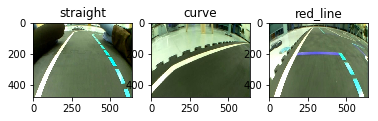

In [187]:
#10 straight , 300 curve , 410 red_line
show=[]
straight = cv2.imread('../dataset/original/10.jpg')
curve = cv2.imread('../dataset/original/320.jpg')
red_line = cv2.imread('../dataset/original/410.jpg')

fig, axes = plt.subplots(1, 3)
  
axes[0].set_title('straight')
axes[0].imshow(straight)
axes[1].set_title('curve')
axes[1].imshow(curve)
axes[2].set_title('red_line')
axes[2].imshow(red_line)

# Resize

In [188]:
image=curve
frame = cv2.resize(image,(100, 75))  

In [189]:
height=frame.shape[0]
width=frame.shape[1]

# Detect red line

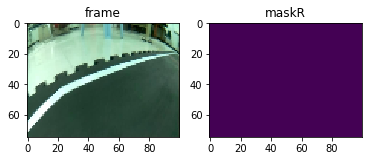

In [190]:
frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
lowerR=np.array([220,70,70])
upperR=np.array([255,160,170])    
maskR = cv2.inRange(frame, lowerR, upperR)
countR = 0

for i in range(width):        
    if maskR[int(height/3)][i] == 255: 
        countR+=1
    if countR > 10:
        print('stop')
        break
        
fig, axes = plt.subplots(1, 2)  
axes[0].set_title('frame')
axes[0].imshow(frame)
axes[1].set_title('maskR')
axes[1].imshow(maskR)

# Gray image

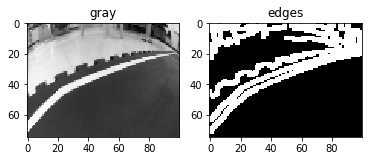

In [191]:
gray=cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,100,200)
edges = dilation(edges, square(3))
# edges[:,width-3:width] = 0 
# edges = ndi.gaussian_filter(edges,2)

fig, axes = plt.subplots(1, 2)  
axes[0].set_title('gray')
axes[0].imshow(gray,cmap='gray')
axes[1].set_title('edges')
axes[1].imshow(edges,cmap='gray')

# Detect line

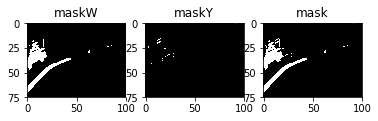

In [192]:
# color range
lowerY=np.array([200,200,0])
upperY=np.array([255,255,210])    
maskY = cv2.inRange(frame, lowerY, upperY)

lowerW=np.array([210,210,210])
upperW=np.array([255,255,255])    
maskW = cv2.inRange(frame, lowerW, upperW)

mask = maskY + maskW

fig, axes = plt.subplots(1, 3)  
axes[0].set_title('maskW')
axes[0].imshow(maskW,cmap='gray')
axes[1].set_title('maskY')
axes[1].imshow(maskY,cmap='gray')
axes[2].set_title('mask')
axes[2].imshow(mask,cmap='gray')

# Crop image

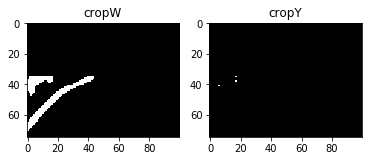

In [193]:
region_of_interest_vertices = [   
    (0, height),
    (0, (height/3)+10),
#     ((width/6), (height/3)+15),
#     (width-(width/6), (height/3)+15),
    (width, (height/3)+10),
    (width, height)]
cropW = region_of_interest(maskW,np.array([region_of_interest_vertices], np.int32))
cropY = region_of_interest(maskY,np.array([region_of_interest_vertices], np.int32))

fig, axes = plt.subplots(1, 2)  
axes[0].set_title('cropW')
axes[0].imshow(cropW,cmap='gray')
axes[1].set_title('cropY')
axes[1].imshow(cropY,cmap='gray')

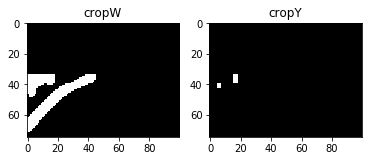

In [194]:
cropW = dilation(cropW, square(3))
cropY = dilation(cropY, square(3))

fig, axes = plt.subplots(1, 2)  
axes[0].set_title('cropW')
axes[0].imshow(cropW,cmap='gray')
axes[1].set_title('cropY')
axes[1].imshow(cropY,cmap='gray')

# Hough Transform

In [195]:
linesW = cv2.HoughLinesP(cropW,rho = 1,theta = 1*np.pi/180,threshold = 40,minLineLength = 10,maxLineGap = 250)
font = cv2.FONT_HERSHEY_SIMPLEX
linesW

array([[[ 0, 67, 41, 34]],

       [[ 0, 63, 31, 38]],

       [[ 0, 70, 34, 36]],

       [[ 0, 64, 39, 34]]], dtype=int32)

In [196]:
linesY = cv2.HoughLinesP(cropY,rho = 1,theta = 1*np.pi/180,threshold = 40,minLineLength = 10,maxLineGap = 250)
font = cv2.FONT_HERSHEY_SIMPLEX
linesY

In [197]:
l=[]
if(linesW is not None): 
    l = np.round(np.array([sum(x)/len(x) for x in zip(*linesW)]))[0].astype('int')
    print(l)

[ 0 66 36 36]


In [198]:
r=[]
if(linesY is not None): 
    r = np.round(np.array([sum(x)/len(x) for x in zip(*linesY)]))[0].astype('int')
    print(r)

# Draw line

0 36 9 39
slope: 0.8333333333333334
[]
slope 0.833


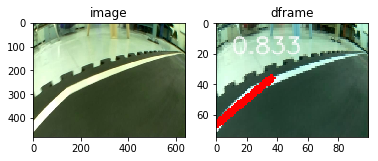

In [199]:
dframe = copy.deepcopy(frame) 
if(len(l)):                
    slope_left = findSlope((l[0],l[1]),(l[2],l[3]),height)
    cv2.line(dframe, (l[0],l[1]),(l[2],l[3]), (255, 0, 0), 3)
else:
    slope_left = 0
print(r)
if(len(r)):                 
    slope_right = findSlope((r[0],r[1]),(r[2],r[3]),height)
    cv2.line(dframe, (r[0],r[1]),(r[2],r[3]), (0, 0, 255), 3)
else:
    slope_right = 0

slope = round(slope_right + slope_left,3)
if(slope > 2):
    slope = 2
elif(slope < -2):
    slope = -2  
print('slope',slope)   
cv2.putText(dframe,str(slope),(10,20), font, 0.5,(255,255,255),1,cv2.LINE_AA)
    
fig, axes = plt.subplots(1, 2)  
axes[0].set_title('image')
axes[0].imshow(image)
axes[1].set_title('dframe')
axes[1].imshow(dframe)